# TWITTER SENTIMENT ANALYSIS

This project involves classifying a set of tweets into two categories :
    1. racist/sexist
    2. non-racist/sexist
    
Sentiment analysis is an application of Natural Language Processing (NLP). It will involve classifying a piece of text as positive, negative, neutral.

### Problem statement

The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets. <br>

Formally, given a training sample of tweets and labels, where <b>label ‘1’ denotes the tweet is racist/sexist</b> and <b>label ‘0’ denotes the tweet is not racist/sexist</b>, your objective is to predict the labels on the given test dataset.

We will begin by loading the libraries that are required in this project. And also we will load the dataset on which we will perform the sentiment analysis.

In [1]:
import re #for regular expression
import nltk #for text manipulation
import string
import warnings 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option("display.max_colwidth",200)
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
#lets dowload the train and test datasets

train = pd.read_csv("train_tweets.csv")
test = pd.read_csv("test_tweets_anuFYb8.csv")

##### Step 1. Data Preprocessing

In [3]:
# lets check a few of the non-racist/sexist tweets

train[train['label']==0].head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo
6,7,0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦
7,8,0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl
8,9,0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦
9,10,0,@user @user welcome here ! i'm it's so #gr8 !


In [4]:
# lets check a few of the racist/sexist tweets

train[train['label']==1].head(10)

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia
56,57,1,@user lets fight against #love #peace
68,69,1,ð©the white establishment can't have blk folx running around loving themselves and promoting our greatness
77,78,1,"@user hey, white people: you can call people 'white' by @user #race #identity #medâ¦"
82,83,1,how the #altright uses &amp; insecurity to lure men into #whitesupremacy
111,112,1,@user i'm not interested in a #linguistics that doesn't address #race &amp; . racism is about #power. #raciolinguistics bringsâ¦


There are quite a many words and characters which are not really required. So, we will try to keep only those words which are important and add value.

In [5]:
#Let's identify the dimensions of both our datasets

train.shape, test.shape

((31962, 3), (17197, 2))

In [6]:
#Let's have a glimpse at label distribution in the train dataset

train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In the train dataset, we have 2,242 (~7%) tweets labeled as racist or sexist, and 29,720 (~93%) tweets labeled as non racist/sexist. So, it is an imbalanced classification challenge.

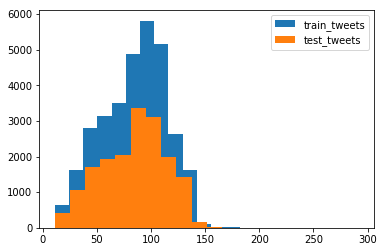

In [7]:
# Let's check the distribution of lengths of tweets, 
# in terms of words, in both traina dntest datasets

length_train = train['tweet'].str.len()
length_test = test['tweet'].str.len()

plt.hist(length_train, bins =20, label ="train_tweets")
plt.hist(length_test, bins =20, label ="test_tweets")
plt.legend()
plt.show()

Before we begin cleaning, let’s first combine train and test datasets. Combining the datasets will make it convenient for us to preprocess the data. Later we will split it back into train and test data.

In [8]:
combined = train.append(test,ignore_index = True)
combined.shape

C:\Users\tarus\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


(49159, 3)

In [9]:
# Let's define a function to remove
# unwanted text patterns from our tweets

def remove_pattern(input_text, pattern):
    r = re.findall(pattern,input_text)
    for i in r:
        input_text = re.sub(i,'',input_text)
    return input_text

1. In our data, the twitter handles are marked as @user(for privacy concerns) and of no use to us as they don't give us any information about the nature of the tweet, so we can simply remove them. <br>
2. Special characters, punctuations, and numbers will not help us in differentiating different type of data so we will simply remove them. <br>
3. Common words, similar words or pronouns dont add much value to our intent and hence we can remove such words a s well- 'his','pdx',all'. <br>
4. Lastly, it is important to normalize the data. For example, reducing different forms of a word to their base meaning used in the same context will help: like-'loving','lovable,'loved'... can be rediced to 'love'. This helps in reducing the total number of unique words in our data without losing a significant amount of information.

In [10]:
# REMOVING TWITTER HANDLES

combined['tidy_tweet'] = np.vectorize(remove_pattern)(combined['tweet'],"@[\w]*")
combined.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


As you can see, all the twitter handles have been removed.
<br>
Let us now remove the punctuations, numbers and special charaters.

In [11]:
# We are going to replace all the text that is not a letter or a '#' with a space " "

combined['tidy_tweet'] = combined['tidy_tweet'].str.replace("[^a-zA-Z#]"," ")
combined.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can t use cause they don t offer wheelchair vans in pdx #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in ur
4,5,0.0,factsguide: society now #motivation,factsguide society now #motivation


After this, we will now remove all the short words having length 3 or less. The length has been chosen as 3, because most adjectives or words that can help us find the nature of our tweets are longer than 3 letters. Again, the whole purpose of carrying out these steps is to reduce the length of the tweets and make them easier to interpret.

In [12]:
combined['tidy_tweet'] = combined['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() 
                                                      if len(w)>3]))
combined.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunctional selfish drags kids into dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks #lyft credit cause they offer wheelchair vans #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


###### TEXT NORMALIZATION 
Here we will use nltk’s PorterStemmer() function to normalize the tweets. But before that we will have to tokenize the tweets. Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.


In [13]:
#tokenizing
tokenized_tweet = combined['tidy_tweet'].apply(lambda x: x.split()) 
tokenized_tweet.head(10)

0                                                      [when, father, dysfunctional, selfish, drags, kids, into, dysfunction, #run]
1                                          [thanks, #lyft, credit, cause, they, offer, wheelchair, vans, #disapointed, #getthanked]
2                                                                                                           [bihday, your, majesty]
3                                                                                                  [#model, love, take, with, time]
4                                                                                                [factsguide, society, #motivation]
5                                   [huge, fare, talking, before, they, leave, chaos, disputes, when, they, there, #allshowandnogo]
6                                                                                                        [camping, tomorrow, danny]
7    [next, school, year, year, exams, think, about, that, #school, #exams, 

In [14]:
# LET US NOW NORMALIZE THE TOKENIZED TWEETS

from nltk.stem.porter import *
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) #stemming

# Let's stich these tokens back together. 
# This can be done by using nltk's MosesDetokenizer function.

for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
combined['tidy_tweet'] = tokenized_tweet

#### STORY GENERATION AND TEXT VISUALIZATION FROM TWEETS

Before we begin, Let us first ask some of the questions related to our data:
1. What are the most common words in our entire dataset?
2. What are the most common words in positive tweets andnegative tweets, respectively?
3. What are the trends assiciated with our dataset?
4. Which trends are associated with either of the sentiments? Are they compatible with our sentiments?
5. How many hashtags are there in a tweet?

Word clouds are the best way to test the most frequently appearing words in your dataset. A wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.

Let’s visualize all the words our data using the wordcloud plot.

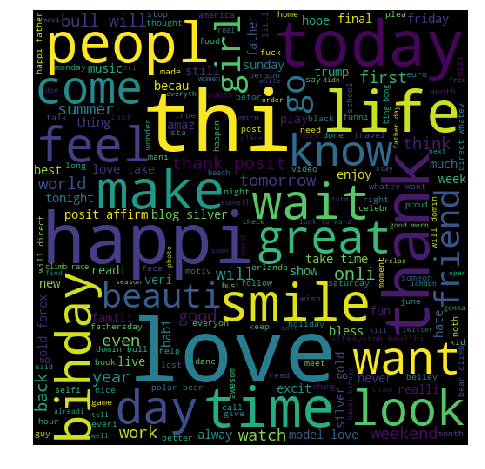

In [15]:
all_words = ' '.join([text for text in combined['tidy_tweet']]) 

from wordcloud import WordCloud
word_cloud = WordCloud(width = 500, height=500,random_state = 21, max_font_size = 100).generate(all_words)
plt.figure(figsize=(10,8))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

We can see most of the words are positive or neutral. But this wordcloud doesn't give us any idea about the words associated with racist/sexist tweets. <br>
Hence, we will plot separate wordclouds for both the classes (racist/sexist or not) in our train data.

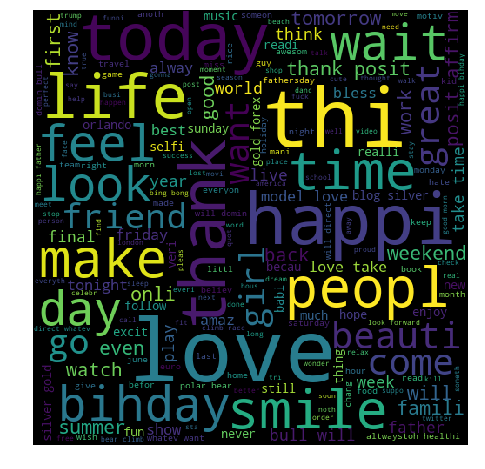

In [16]:
#WORDCLOUD FOR NON-RACIST/SEXIST TWEETS

normal_words = ' '.join([text for text in combined['tidy_tweet'][combined['label']==0]])
wordcloud = WordCloud(width = 500, height = 500, random_state = 21, max_font_size=100).generate(normal_words)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Most of the frequent words are compatible with the sentiment, i.e, non-racist/sexists tweets. Similarly, we will plot the word cloud for the other sentiment. Expect to see negative, racist, and sexist terms.



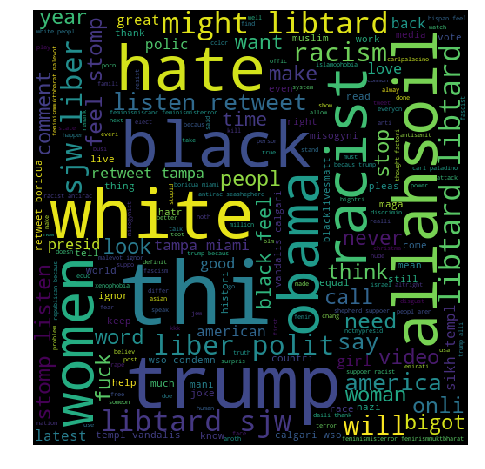

In [17]:
negative_words = ' '.join([text for text in combined['tidy_tweet'][combined['label']==1]])
wordcloud = WordCloud(width=500,height=500,random_state=21,max_font_size=100).generate(negative_words)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

As we can clearly see, most of the words have negative connotations. So, it seems we have a pretty good text data to work on. Next we will see the hashtags/trends in our twitter data.

Hashtags in twitter are synonymous with the ongoing trends on twitter at any particular point in time. We should try to check whether these hashtags add any value to our sentiment analysis task, i.e., they help in distinguishing tweets into the different sentiments.
<br>

We will store all the trend terms in two separate lists — one for non-racist/sexist tweets and the other for racist/sexist tweets.

In [18]:
# FUNCTION TO COLLECT ALL THE HASHTAGS

def hashtag_extract(word):
    hashtags=[] 
    # Loop over the words in the tweet
    for i in word:
        ht=re.findall(r"#(\w+)",i)
        hashtags.append(ht)
    return hashtags


In [19]:
# extracting hashtags from non racist/sexist tweets
HT_Regular = hashtag_extract(combined['tidy_tweet'][combined['label']==0])

# extracting hashtags from racist/sexist tweets
HT_Negative = hashtag_extract(combined['tidy_tweet'][combined['label']==1])

# unnesting list
HT_Regular = sum(HT_Regular,[])
HT_Negative = sum(HT_Negative,[])

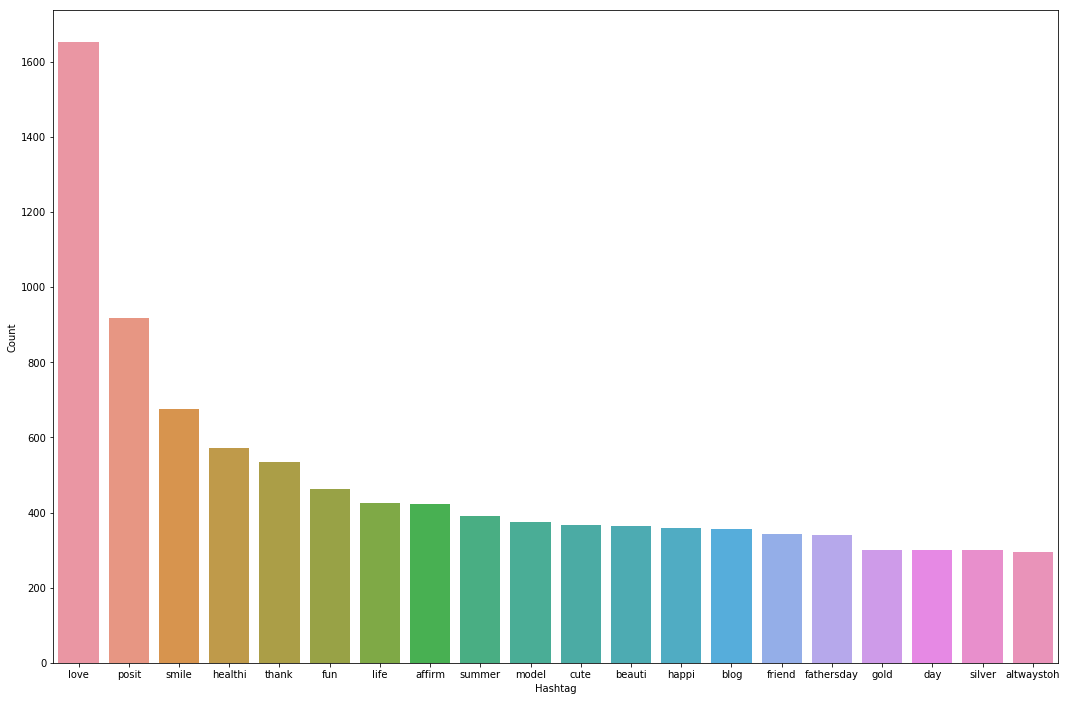

In [20]:
# NOW WE HAVE OUR PREPARED LISTS OF HASHTAGS FOR BOTH SENTIMENTS
# FIRST, LETS CHECKOUT THE HASHTAGS IN THE NON-RACIST/SEXIST TWEETS

a= nltk.FreqDist(HT_Regular)
d= pd.DataFrame({'Hashtag':list(a.keys()),'Count': list(a.values())})

#selecting the top 20 trending hashtags
d = d.nlargest(columns = 'Count',n=20)
plt.figure(figsize=(18,12))
ax = sns.barplot(data= d ,x = "Hashtag", y="Count")
ax.set(ylabel='Count')
plt.show()

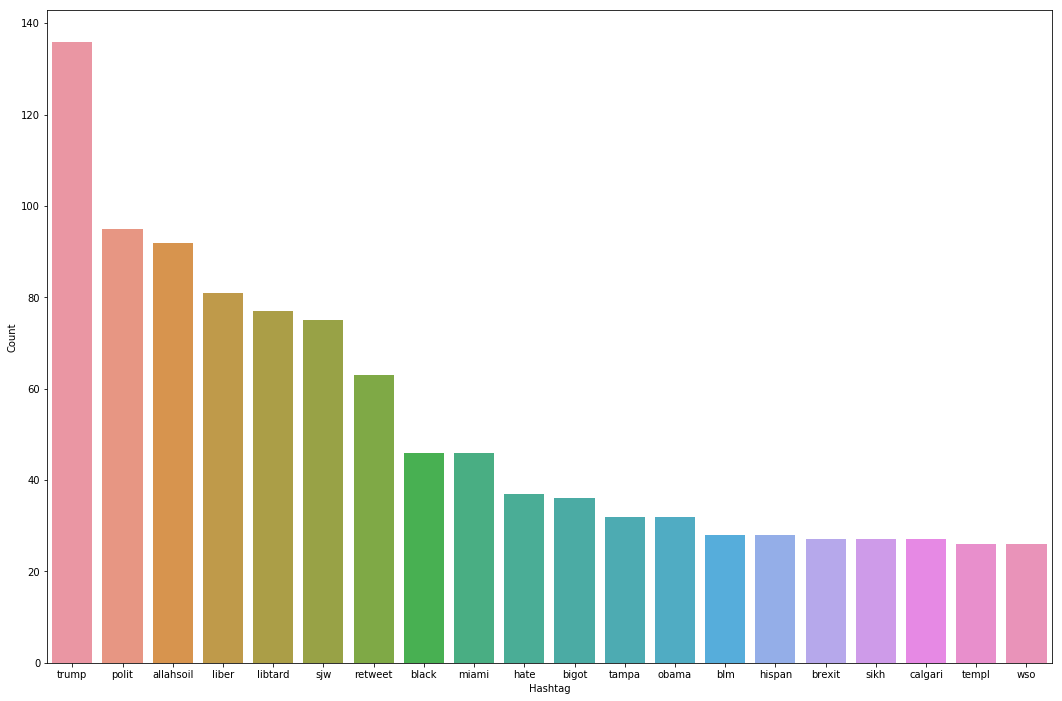

In [21]:
# NOW LETS CHECKOUT THE HASHTAGS IN THE NON-RACIST/SEXIST TWEETS
b = nltk.FreqDist(HT_Negative)
e = pd.DataFrame({"Hashtag": list(b.keys()),"Count":list(b.values())})

#selecting the top 20 trending hashtags
e=e.nlargest(columns='Count',n =20)
plt.figure(figsize=(18,12))
ax = sns.barplot(data = e, x= "Hashtag",y="Count")
ax.set(ylabel='Count')
plt.show()

As expected, most of the terms are negative with a few neutral terms as well. So, it’s not a bad idea to keep these hashtags in our data as they contain useful information. Next, we will try to extract features from the tokenized tweets.

<b>Bag of Words</b>

Consider a Corpus C of D documents {d1,d2…..dD} and N unique tokens extracted out of the corpus C. The N tokens (words) will form a dictionary and the size of the bag-of-words matrix M will be given by D X N. Each row in the matrix M contains the frequency of tokens in document D(i).<br>

Let us understand this using a simple example.<br>

D1: He is a lazy boy. She is also lazy.<br>

D2: Smith is a lazy person.<br>

The dictionary created would be a list of unique tokens in the corpus =[‘He’,’She’,’lazy’,’boy’,’Smith’,’person’]
<br>
Here, D=2, N=6
<br>
The matrix M of size 2 X 6

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
import gensim

C:\Users\tarus\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\tarus\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [23]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english') 
bow = bow_vectorizer.fit_transform(combined['tidy_tweet']) 
bow.shape

(49159, 1000)

This is another method which is based on the frequency method but it is different to the bag-of-words approach in the sense that it takes into account not just the occurrence of a word in a single document (or tweet) but in the entire corpus.<br>

TF-IDF works by penalising the common words by assigning them lower weights while giving importance to words which are rare in the entire corpus but appear in good numbers in few documents.<br>

Let’s have a look at the important terms related to TF-IDF:<br>

TF = (Number of times term t appears in a document)/(Number of terms in the document)<br>

IDF = log(N/n), where, N is the number of documents and n is the number of documents a term t has appeared in.<br>

TF-IDF = TF*IDF<br>

In [24]:
#from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df = 0.90, min_df=2,max_features=1000,stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(combined['tidy_tweet'])
tfidf.shape

(49159, 1000)

Word embeddings are the modern way of representing words as vectors. The objective of word embeddings is to redefine the high dimensional word features into low dimensional feature vectors by preserving the contextual similarity in the corpus. <br>

The advantages of using word embeddings over BOW or TF-IDF are:

1. Dimensionality reduction - significant reduction in the no. of features required to build a model.

2. It capture meanings of the words, semantic relationships and the different types of contexts they are used in.



<b>Word2Vec Embeddings</b><br>
Word2Vec is a combination of two techniques - <b>CBOW(Cintinuous Bag Of Words)</b> and <b>Skip-gram model</b>. Both are shallow neural networks which map word(s) to get the target variable which is also a word(s). They learn weights which act as word vector representations.
<br><br>

CBOW tends to predict the probability of a word given a context. A context may be a single adjacent word or a group of surrounding words. The Skip-gram model works in the reverse manner, it tries to predict the context for a given word

Skip-gram model advantages:<br>
1. It captures 2 semantics for a single word i.e. it will have two vector representations of 'apple'. One for the company Apple and the other for the fruit.<br>
2. Skip-gram with negative sub-samplingoutperforms CBOW.

In [25]:
#training a Word2Vec model

tokenized_tweet = combined['tidy_tweet'].apply(lambda x: x.split())
model_w2v = gensim.models.Word2Vec(tokenized_tweet,
                                  size=200, window=5,
                                  min_count=2, sg=1, hs=0,
                                  negative = 10, workers=2, seed=34)
model_w2v.train(tokenized_tweet, total_examples = len(combined['tidy_tweet']), epochs=20)

(6510028, 7536020)

The model will pull out the most similar words when we specify a word.

In [26]:
model_w2v.wv.most_similar(positive='dinner')

[('spaghetti', 0.5608973503112793),
 ('#avocado', 0.5605522394180298),
 ('#biall', 0.5536847114562988),
 ('cookout', 0.553463339805603),
 ('noodl', 0.5485217571258545),
 ('#cellar', 0.548511803150177),
 ('fav', 0.5477572083473206),
 ('spinach', 0.5435640215873718),
 ('gown', 0.5399975180625916),
 ('#bihdaydinn', 0.5394441485404968)]

In [27]:
model_w2v.wv.most_similar(positive="trump")

[('donald', 0.55097895860672),
 ('phoni', 0.5338274240493774),
 ('hillari', 0.526049017906189),
 ('unstabl', 0.517707347869873),
 ('melo', 0.5155061483383179),
 ('#delegaterevolt', 0.5135624408721924),
 ('endors', 0.5085973739624023),
 ('tomlin', 0.5077483654022217),
 ('jibe', 0.5060276985168457),
 ('unfavor', 0.5057120323181152)]

The above two examples show that the model performs well for finding the most similar words for a given word. <br>
This is because it has learned vectors for every unique word in our data and then uses the cosine similarity to find out the most similar word(s).

In [28]:
#vector representation of any word
model_w2v['food']

array([-0.7256546 ,  0.27543774,  0.33094007, -0.33446476,  0.47170997,
        1.0710285 ,  0.21826008,  0.24722686, -0.09940513,  0.15943506,
       -0.49886042,  0.09435687,  0.3435975 , -0.27806607, -0.6401219 ,
        0.00740431, -0.07464737, -0.5082509 ,  0.3592737 , -0.07198352,
       -0.15943064, -0.19086613, -1.0314866 , -0.00967559, -0.5982268 ,
       -0.26859123, -0.30258194, -0.03187546,  0.09446958, -0.24792281,
        0.378144  ,  0.4120137 , -0.2184614 , -0.37690195,  0.27337912,
       -0.03065056,  0.34655473,  0.26926318, -0.75696135,  0.18862276,
        0.5893965 , -0.14576998,  0.65063536, -0.35450625,  0.2501471 ,
       -0.6735711 , -0.24159066,  0.406613  ,  0.250935  , -0.04503336,
        0.1914367 , -0.16781618,  0.20961575,  1.0224566 ,  0.17743577,
        0.2907058 , -0.11152862,  0.15871911, -0.04125115, -0.08643369,
       -0.59311056,  0.0933416 , -0.04859371,  0.78694797, -0.1981847 ,
       -0.10848204, -0.17500052, -0.6355356 ,  0.82406175,  0.24

In [29]:
#finding the length of the vector
len(model_w2v['food'])

200

##### Preparing Vectors for Tweets

Our data contains tweets and not just words and hence, we have to use the word vectors from word2vec model to create vector representation for an entire tweet.<br>
This can be achieved by taking the mean of all word vectors present in the tweet. Length of the resultant tweet will be the same i.e 200. The process is repeated for all tweets in the dataset and obtain their vectors.<br><br>
The function defined below will be used to create a vector for each tweet by taking the average of the vectors of the words present in the tweet.

In [30]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1,size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1,size))
            count += 1
        except KeyError: # handling the case where the token is not in the vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [31]:
# Preparing the word2vec feature set

wordvec_arrays = np.zeros((len(tokenized_tweet),200))
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i],200)
    wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(49159, 200)

Word2Vec gave us 200 features against the Bag of Words and TF-IDF which had 1000 features.

#### Doc2Vec Embedding

It is an unsupervised algorithm to generate vectors for sentence/paragraphs/documents. It is an extension of the word2vec. 

In [32]:
# looding the required libraries

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import LabeledSentence

To implement doc2vec, we have to labelise or tag each tokenised tweet with unique IDs. We can do so by using Gensim’s LabeledSentence() function.

In [33]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

labeled_tweets = add_label(tokenized_tweet) # label all tweets

In [34]:
labeled_tweets[:6]

[LabeledSentence(words=['when', 'father', 'dysfunct', 'selfish', 'drag', 'kid', 'into', 'dysfunct', '#run'], tags=['tweet_0']),
 LabeledSentence(words=['thank', '#lyft', 'credit', 'caus', 'they', 'offer', 'wheelchair', 'van', '#disapoint', '#getthank'], tags=['tweet_1']),
 LabeledSentence(words=['bihday', 'your', 'majesti'], tags=['tweet_2']),
 LabeledSentence(words=['#model', 'love', 'take', 'with', 'time'], tags=['tweet_3']),
 LabeledSentence(words=['factsguid', 'societi', '#motiv'], tags=['tweet_4']),
 LabeledSentence(words=['huge', 'fare', 'talk', 'befor', 'they', 'leav', 'chao', 'disput', 'when', 'they', 'there', '#allshowandnogo'], tags=['tweet_5'])]

In [35]:
#training a doc2vec model

model_d2v = gensim.models.Doc2Vec(dm=1, # for 'distributed memory' model
                                 dm_mean = 1, #for using mean of the context word vectors
                                 size = 200,  #no. of desired features
                                  window=5, #width of context window
                                 nehgative=7, min_count = 5, workers = 3,
                                 alpha=0.1, #learning rate
                                 seed=23)
model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])

model_d2v.train(labeled_tweets, total_examples= len(combined['tidy_tweet']),epochs=15)

C:\Users\tarus\Anaconda3\lib\site-packages\gensim\models\doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 49159/49159 [00:00<00:00, 1369627.22it/s]


Preparing doc2vec Feature Set

In [36]:
docvec_arrays = np.zeros((len(tokenized_tweet), 200)) 
for i in range(len(combined)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,200))    

docvec_df = pd.DataFrame(docvec_arrays) 
docvec_df.shape

(49159, 200)

<b>Modeling</b>

With all the pre-modeling stages required to get the data in proper form and shape, it is time for building moddels on the datasets with different feature sets prepared earlier sections- Bag of Words, TF_IDF, word2vec, doc2vec vectors.<br>
The following algoritms will be used:<br>
1. Logistic Regression<br>
2. Support Vector Machine<br>
3. RandomForest<br>
4. XGBoost

<b>Evaluation Metric</b><br>
F1 score is being used as the evaluation metric. It is the weighted average of Precision and Recall. Thus, the score takes both false positive and false negatives into account.. Suitable for uneven class distribution problems.

Important components of F1 score are:
<br>
1. True Positives(TP) -  Correctly predicted positive values i.e. the actual class and predicted class values are both yes.<br>
2. True Negatives(TN) - Correctly predicted negative values i.e. values of actaul and predicted class both are no.<br>
3. False Positive(FP) - Actual class is no but predicted class is yes.<br>
4. False Negatives(FN) - Actual class is yes but predicted class is no.

Precision = TP/(TP+NP)<br>
Recall = TP(TP+FN)

F1Score = 2(Recall)(Precision)/(Recall + Precision)

<b>1. Logistic Regression</b><br>
It is a classification algorithm which predicts a binary outcome(1/0, Yes/No, True/False) for a given set of independent variables. It predicts the probability of occurence of an event by fitting datra to a logit function.<br><br>
log(p/(1-p)) = b0 + b(Age)<br><br><br>
Loading the libraries

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

<b>Bag-of-Words Features</b>

In [38]:
#Extracting train and test Bow Features
train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

In [39]:
#Splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, 
                                                          train['label'],
                                                          random_state=42, 
                                                          test_size=0.3)

In [40]:
lreg = LogisticRegression()

In [41]:
#training the model 
lreg.fit(xtrain_bow, ytrain)

prediction = lreg.predict_proba(xvalid_bow) #predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 #if prediction is greater than or equal to 0.3 than 1 else 0

C:\Users\tarus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [42]:
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int) #calculating f1 score for validation set

0.5307820299500832

Making predictions for test dataset and creating a submission file

In [43]:
test_pred = lreg.predict_proba(test_bow) 
test_pred_int = test_pred[:,1] >= 0.3 
test_pred_int = test_pred_int.astype(np.int) 
test['label'] = test_pred_int 
submission = test[['id','label']] 
submission.to_csv('sub_lreg_bow.csv', index=False) # writing data to a CSV file

In [44]:
#Check the submission file by simply printing submission
print(submission)

          id  label
0      31963      0
1      31964      0
2      31965      0
3      31966      0
4      31967      0
5      31968      0
6      31969      0
7      31970      0
8      31971      0
9      31972      0
10     31973      0
11     31974      0
12     31975      0
13     31976      0
14     31977      0
15     31978      0
16     31979      0
17     31980      0
18     31981      0
19     31982      1
20     31983      0
21     31984      0
22     31985      0
23     31986      0
24     31987      0
25     31988      0
26     31989      1
27     31990      0
28     31991      0
29     31992      0
...      ...    ...
17167  49130      0
17168  49131      0
17169  49132      0
17170  49133      0
17171  49134      0
17172  49135      0
17173  49136      0
17174  49137      0
17175  49138      0
17176  49139      1
17177  49140      0
17178  49141      0
17179  49142      0
17180  49143      0
17181  49144      0
17182  49145      0
17183  49146      0
17184  49147      0


<b>TF-IDF Features</b>

In [45]:
train_tfidf = tfidf[:31962,:] 
test_tfidf = tfidf[31962:,:] 
xtrain_tfidf = train_tfidf[ytrain.index] 
xvalid_tfidf = train_tfidf[yvalid.index]
lreg.fit(xtrain_tfidf, ytrain) 
prediction = lreg.predict_proba(xvalid_tfidf) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int) # calculating f1 score for the validation set

0.5446507515473032

<b>Word2Vec Features</b>

In [46]:
train_w2v = wordvec_df.iloc[:31962,:] 
test_w2v = wordvec_df.iloc[31962:,:] 
xtrain_w2v = train_w2v.iloc[ytrain.index,:] 
xvalid_w2v = train_w2v.iloc[yvalid.index,:]
lreg.fit(xtrain_w2v, ytrain) 
prediction = lreg.predict_proba(xvalid_w2v) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)

0.6189069423929099

<b>Doc2Vec Features</b>

In [47]:
train_d2v = docvec_df.iloc[:31962,:] 
test_d2v = docvec_df.iloc[31962:,:] 
xtrain_d2v = train_d2v.iloc[ytrain.index,:] 
xvalid_d2v = train_d2v.iloc[yvalid.index,:]
lreg.fit(xtrain_d2v, ytrain) 
prediction = lreg.predict_proba(xvalid_d2v) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)

C:\Users\tarus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.36991150442477877

F1 Score for each of the vectors are:<br>
Bag-of-Words Features - 0.5307820299500832<br>
TF-IDF Features - 0.5446507515473032<br>
Word2Vec Features - 0.6212454212454213<br>
Doc2Vec Features - 0.3407671721677074

Doc2Vec feature has the worst score among the four features.

<b>2. Support Vector Machine (SVM)</b><br>
It is asupervised machine learning algorithm which can be used both for classification or regression challenges. Each data item as a point in n-dimensional space (where n is the number of features you have) with the value of each feature being the value of a particular coordinate.<br><br>
Loading the libraries

In [48]:
from sklearn import svm

<b>Bag-of-Words Features</b>

In [49]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_bow, ytrain) 
prediction = svc.predict_proba(xvalid_bow) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)

0.5088207985143919

In [50]:
test_pred = svc.predict_proba(test_bow) 
test_pred_int = test_pred[:,1] >= 0.3 
test_pred_int = test_pred_int.astype(np.int) 
test['label'] = test_pred_int 
submission = test[['id','label']] 
submission.to_csv('sub_svm_bow.csv', index=False)

<b>TF-IDF Features</b>

In [51]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_tfidf, ytrain) 
prediction = svc.predict_proba(xvalid_tfidf) 
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)

0.5109489051094891

<b>Word2Vec Features</b>

In [52]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_w2v, ytrain) 
prediction = svc.predict_proba(xvalid_w2v) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)

0.6264682850430697

<b>Doc2Vec Features</b>

In [54]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_d2v, ytrain) 
prediction = svc.predict_proba(xvalid_d2v) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
f1_score(yvalid, prediction_int)

0.17577197149643703

<b>3. Random Forest</b>

It is a machine learning algorithm capable of performing both regression and classification tasks. In Random Forest, we grow multiple trees as opposed to a single decision tree.<br>
To classify a new object based on attributes, each tree gives a classification and the tree “votes” for that class. The forest chooses the classification having the most votes (over all the trees in the forest).

It works in the following manner. Each tree is planted & grown as follows:<br>

1. Assume number of cases in the training set is N. Then, sample of these N cases is taken at random but with replacement. This sample will be the training set for growing the tree.<br>

2. If there are M input variables, a number m (m<M) is specified such that at each node, m variables are selected at random out of the M. The best split on these m variables is used to split the node. The value of m is held constant while we grow the forest.<br>

3. Each tree is grown to the largest extent possible and there is no pruning.<br>

4. Predict new data by aggregating the predictions of the ntree trees (i.e., majority votes for classification, average for regression).

In [55]:
#Importing the library

from sklearn.ensemble import RandomForestClassifier

<b>Bag-of-Words Features</b>

In [56]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_bow, ytrain) 
prediction = rf.predict(xvalid_bow) 
# validation score 
f1_score(yvalid, prediction)

0.5529225908372828

In [57]:
test_pred = rf.predict(test_bow) 
test['label'] = test_pred 
submission = test[['id','label']] 
submission.to_csv('sub_rf_bow.csv', index=False)

<b>TF-IDF Features</b>

In [58]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_tfidf, ytrain) 
prediction = rf.predict(xvalid_tfidf) 
f1_score(yvalid, prediction)

0.562152133580705

<b>Word2Vec Features</b>

In [59]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_w2v, ytrain) 
prediction = rf.predict(xvalid_w2v) 
f1_score(yvalid, prediction)

0.5112299465240642

<b>Doc2Vec Features</b>

In [60]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_d2v, ytrain) 
prediction = rf.predict(xvalid_d2v) 
f1_score(yvalid, prediction)

0.07865168539325842

<b>4. XGBoost</b>

It is an advanced implementation of gradient boosting algorithm. It has both linear model solver and tree learning algos. It has additional features for doing cross validation and finding important variables. There are many parameters which need to be controlled to optimize the model.<br><br>
Some key benefits of XGBoost are:<br>

1. <b>Regularization</b> - helps in reducing overfitting<br>

2. <b>Parallel Processing</b> - XGBoost implements parallel processing and is blazingly faster as compared to GBM.<br>

3. <b>Handling Missing Values</b> - It has an in-built routine to handle missing values.<br>

4. <b>Built-in Cross-Validation</b> - allows user to run a cross-validation at each iteration of the boosting process

In [61]:
#importing library

from xgboost import XGBClassifier

<b>Bag-of-Words Features</b>

In [62]:
xgb_model = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_bow, ytrain) 
prediction = xgb_model.predict(xvalid_bow) 
f1_score(yvalid, prediction)
test_pred = xgb_model.predict(test_bow) 
test['label'] = test_pred 
submission = test[['id','label']] 
submission.to_csv('sub_xgb_bow.csv', index=False)

In [63]:
print(f1_score(yvalid, prediction))

0.5130687318489837


<b>TF-IDF Features</b>

In [64]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_tfidf, ytrain) 
prediction = xgb.predict(xvalid_tfidf) 
f1_score(yvalid, prediction)

0.5185891325071497

<b>Word2Vec Features</b>

In [65]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthreads=3).fit(xtrain_w2v, ytrain)
prediction = xgb.predict(xvalid_w2v)
f1_score(yvalid, prediction)

0.6425992779783394

<b>Doc2Vec Features</b>

In [66]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(xtrain_d2v, ytrain) 
prediction = xgb.predict(xvalid_d2v) 
f1_score(yvalid, prediction)

0.34559643255295425

XGBoost has had the best performance with Word2Vec model. <br>
XGBoost has many fine tuning parameters and sometimes it becomes tricky to use them.
<br>We will use DMatrices which can obtain both the target and the features.

In [67]:
import xgboost as xgb

In [68]:
dtrain = xgb.DMatrix(xtrain_w2v, label=ytrain)
dvalid = xgb.DMatrix(xvalid_w2v, label=yvalid)
dtest = xgb.DMatrix(test_w2v)

#parameters to be tuned

parameters = {'objective':'binary:logistic',
             'max_depth':6,
             'min_child_weight':1,
             'eta':0.3,
             'subsample':1,
             'colsample_bytree':1
             }

C:\Users\tarus\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [69]:
#custom evaluation metric calculate F! Score
def custom_eval(preds, dtrain):
    labels = dtrain.get_label().astype(np.int)
    preds = (preds >=0.3).astype(np.int)
    return [('f1_score', f1_score(labels, preds))]

<b>General Approach for Parameter Tuning</b><br>
1. Choose a relatively high learning rate. Usually 0.3 is used as a learning rate at this stage.<br>
2. Tune tree-specific parameters such as min_child_weight, max_depth, colsample_bytree, subsample with a fixed learning rate.<br>
3. Tune the learning rate.<br>
4. Tune gamma to avoid overfitting.

In [73]:
gridsearch_params = [(max_depth, min_child_weight)
                    for max_depth in range(6,10)
                        for min_child_weight in range(5,8)
                    ]
max_f1 = 0. #initialising with 0
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
    max_depth, min_child_weight))
    
    #updating the parameters
    parameters['max_depth'] = max_depth
    parameters['min_child_weight'] = min_child_weight
    
    #corss-validation
    cv_results = xgb.cv(parameters, dtrain, feval=custom_eval,
                        num_boost_round=200, maximize=True, seed=16,
                       nfold=5,early_stopping_rounds=10)
#finding best F1 score

mean_f1 = cv_results['test-f1_score-mean'].max()

boost_rounds = cv_results['test-f1_score-mean'].argmax()
print("\t F1 Score {} for {} rounds".format(mean_f1, boost_rounds))
if mean_f1 > max_f1:
    max_f1 = mean_f1
    best_params = (max_depth, min_child_weight)
    
print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

CV with max_depth=6, min_child_weight=5
CV with max_depth=6, min_child_weight=6
CV with max_depth=6, min_child_weight=7
CV with max_depth=7, min_child_weight=5
CV with max_depth=7, min_child_weight=6
CV with max_depth=7, min_child_weight=7
CV with max_depth=8, min_child_weight=5
CV with max_depth=8, min_child_weight=6
CV with max_depth=8, min_child_weight=7
CV with max_depth=9, min_child_weight=5
CV with max_depth=9, min_child_weight=6
CV with max_depth=9, min_child_weight=7


C:\Users\tarus\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


	 F1 Score 0.6886196 for 64 rounds
Best params: 9, 7, F1 Score: 0.6886196


In [74]:
#Updating max_depth and min_child_weight parameters

parameters['max_depth'] = 8
parameters['min_child_weight'] = 6

In [75]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(5,10)]
    for colsample in [i/10. for i in range(5,10)] ]
max_f1 = 0
best_params = None
for subsample, colsample in gridsearch_params:
    print("CV with subsample={}, colsample={}".format(subsample,
                                                     colsample))
    #updating the parameters
    parameters['colsample'] = colsample
    parameters['subsample'] = subsample
    cv_results = xgb.cv(
        parameters,
        dtrain,
        feval = custom_eval,
        num_boost_round=200,
        maximize=True,
        seed=16, nfold=5,
        early_stopping_rounds=10
    )
#finding the best f1 score
mean_f1 = cv_results['test-f1_score-mean'].max()
boost_rounds = cv_results['test-f1_score-mean'].argmax()
print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
if mean_f1 > max_f1:
    max_f1 = mean_f1
    best_params = (subsample, colsample) 
        
print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

CV with subsample=0.5, colsample=0.5
CV with subsample=0.5, colsample=0.6
CV with subsample=0.5, colsample=0.7
CV with subsample=0.5, colsample=0.8
CV with subsample=0.5, colsample=0.9
CV with subsample=0.6, colsample=0.5
CV with subsample=0.6, colsample=0.6
CV with subsample=0.6, colsample=0.7
CV with subsample=0.6, colsample=0.8
CV with subsample=0.6, colsample=0.9
CV with subsample=0.7, colsample=0.5
CV with subsample=0.7, colsample=0.6
CV with subsample=0.7, colsample=0.7
CV with subsample=0.7, colsample=0.8
CV with subsample=0.7, colsample=0.9
CV with subsample=0.8, colsample=0.5
CV with subsample=0.8, colsample=0.6
CV with subsample=0.8, colsample=0.7
CV with subsample=0.8, colsample=0.8
CV with subsample=0.8, colsample=0.9
CV with subsample=0.9, colsample=0.5
CV with subsample=0.9, colsample=0.6
CV with subsample=0.9, colsample=0.7
CV with subsample=0.9, colsample=0.8
CV with subsample=0.9, colsample=0.9


C:\Users\tarus\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


	F1 Score 0.6726954 for 43 rounds
Best params: 0.9, 0.9, F1 Score: 0.6726954


In [77]:
#Updating subsample and colsample_bytree

parameters['subsample'] = .9 
parameters['colsample_bytree'] = .5

In [78]:
#tuning the learning rate

max_f1 = 0. 
best_params = None 
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
     # Update ETA
    parameters['eta'] = eta

     # Run CV
    cv_results = xgb.cv(
        parameters,
        dtrain,
        feval= custom_eval,
        num_boost_round=1000,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=20
    )

     # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].argmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = eta 
print("Best params: {}, F1 Score: {}".format(best_params, max_f1))

CV with eta=0.3


C:\Users\tarus\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


	F1 Score 0.6903742 for 53 rounds
CV with eta=0.2
	F1 Score 0.6907116 for 90 rounds
CV with eta=0.1
	F1 Score 0.6900978 for 152 rounds
CV with eta=0.05
	F1 Score 0.6868972 for 216 rounds
CV with eta=0.01
	F1 Score 0.1302024 for 0 rounds
CV with eta=0.005
	F1 Score 0.1302024 for 0 rounds
Best params: 0.2, F1 Score: 0.6907116


In [80]:
parameters['eta'] = 0.1

parameters

{'objective': 'binary:logistic',
 'max_depth': 8,
 'min_child_weight': 6,
 'eta': 0.1,
 'subsample': 0.9,
 'colsample_bytree': 0.5,
 'colsample': 0.9}

We can now use these tuned parameters in our xgboost model. We have used early stopping of 10 which means if the model’s performance doesn’t improve under 10 rounds, then the model training will be stopped.

In [82]:
xgb_model = xgb.train(
    parameters,
    dtrain,
    feval= custom_eval,
    num_boost_round= 1000,
    maximize=True,
    evals=[(dvalid, "Validation")],
    early_stopping_rounds=10
 )

[0]	Validation-error:0.067786	Validation-f1_score:0.133165
Multiple eval metrics have been passed: 'Validation-f1_score' will be used for early stopping.

Will train until Validation-f1_score hasn't improved in 10 rounds.
[1]	Validation-error:0.05767	Validation-f1_score:0.133165
[2]	Validation-error:0.055897	Validation-f1_score:0.133165
[3]	Validation-error:0.056836	Validation-f1_score:0.133165
[4]	Validation-error:0.05475	Validation-f1_score:0.133165
[5]	Validation-error:0.055063	Validation-f1_score:0.371382
[6]	Validation-error:0.054542	Validation-f1_score:0.454943
[7]	Validation-error:0.053499	Validation-f1_score:0.509574
[8]	Validation-error:0.053395	Validation-f1_score:0.544794
[9]	Validation-error:0.053082	Validation-f1_score:0.576848
[10]	Validation-error:0.053186	Validation-f1_score:0.588638
[11]	Validation-error:0.052769	Validation-f1_score:0.586895
[12]	Validation-error:0.052769	Validation-f1_score:0.590875
[13]	Validation-error:0.052143	Validation-f1_score:0.601824
[14]	Vali

In [83]:
test_pred = xgb_model.predict(dtest) 
test['label'] = (test_pred >= 0.3).astype(np.int) 
submission = test[['id','label']] 
submission.to_csv('sub_xgb_w2v_finetuned.csv', index=False)

Now it’s time to wrap-up things. Let’s quickly revisit what we have learned in this course, initially we cleaned our raw text data, then we learned about 4 different types of feature-set that we can extract from any text data, and finally we used these feature-sets to build models for sentiment analysis.<br>
Word2Vec features turned out to be most useful. Whereas XGBoost with Word2Vec features was the best model for this problem. This clearly shows the power of word embeddings in dealing with NLP problems.